In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


In [2]:
from conllu import parse_incr

def read_tags(filename):
    data = {'words': [], 'tags': []}
    with open(filename) as f:
        for sent in tqdm(parse_incr(f)):
            words = [tok['form'] for tok in sent]
            tags = [tok['upos'] for tok in sent]
            data['words'].append(words)
            data['tags'].append(tags)
    return pd.DataFrame(data)

In [3]:
train_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-train.conllup')
valid_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-dev.conllup')
test_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-test.conllup')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
tags = train_df['tags'].explode().unique()
index_to_tag = {i:t for i,t in enumerate(tags)}
tag_to_index = {t:i for i,t in enumerate(tags)}

In [5]:
from datasets import Dataset, DatasetDict

ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df)
ds['validation'] = Dataset.from_pandas(valid_df)
ds['test'] = Dataset.from_pandas(test_df)
ds

DatasetDict({
    train: Dataset({
        features: ['words', 'tags'],
        num_rows: 14305
    })
    validation: Dataset({
        features: ['words', 'tags'],
        num_rows: 1654
    })
    test: Dataset({
        features: ['words', 'tags'],
        num_rows: 1721
    })
})

In [6]:
ds['train'].to_pandas()

,words,tags
0,"[El, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO..."
1,"[Sobre, la, oferta, de, interconexión, con, Te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D..."
2,"[Afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO..."
3,"[La, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD..."
4,"[Durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P..."
...,...,...
14300,"[Y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ..."
14301,"[Conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,..."
14302,"[Cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON..."
14303,"[Carlos, y, Fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO..."


In [7]:
from transformers import AutoTokenizer

transformer_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(transformer_name)

In [8]:
x = ds['train'][0]
tokenized_input = tokenizer(x['words'], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=['tokens', 'word ids'])

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
tokens,<s>,▁El,▁presidente,▁de,▁el,▁órgano,▁regula,dor,▁de,▁las,...,▁Tele,f,ónica,▁a,▁otros,▁operador,es,▁,.,</s>
word ids,None,0,1,2,3,4,5,5,6,7,...,39,39,39,40,41,42,42,43,43,None


In [9]:
# https://arxiv.org/pdf/1810.04805.pdf
# Section 5.3
# We use the representation of the first sub-token as the input to the token-level classifier over the NER label set.

# default value for CrossEntropyLoss ignore_index parameter
ignore_index = -100

def tokenize_and_align_labels(batch):
    labels = []
    # tokenize batch
    tokenized_inputs = tokenizer(
        batch['words'],
        truncation=True,
        is_split_into_words=True,
    )
    # iterate over batch elements
    for i, tags in enumerate(batch['tags']):
        label_ids = []
        previous_word_id = None
        # get word ids for current batch element
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        # iterate over tokens in batch element
        for word_id in word_ids:
            if word_id is None or word_id == previous_word_id:
                # ignore if not a word or word id has already been seen
                label_ids.append(ignore_index)
            else:
                # get tag id for corresponding word
                tag_id = tag_to_index[tags[word_id]]
                label_ids.append(tag_id)
            # remember this word id
            previous_word_id = word_id
        # save label ids for current batch element
        labels.append(label_ids)
    # store labels together with the tokenizer output
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

In [10]:
train_ds = ds['train'].map(tokenize_and_align_labels, batched=True)
eval_ds = ds['validation'].map(tokenize_and_align_labels, batched=True)
train_ds.to_pandas()

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

,words,tags,input_ids,attention_mask,labels
0,"[El, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO...","[0, 540, 9692, 8, 88, 103633, 15913, 1846, 8, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 1, 2, 0, 1, 3, -100, 2, 0, 4, -100, ..."
1,"[Sobre, la, oferta, de, interconexión, con, Te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D...","[0, 44125, 21, 19806, 8, 1940, 2271, 3355, 194...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 2, 0, 1, 2, 1, -100, -100, -100, 2, 4, ..."
2,"[Afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO...","[0, 62, 38949, 849, 41, 58453, 88, 166220, 620...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 6, -100, -100, 7, 6, 0, 1, 3, 10, 7, 6,..."
3,"[La, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD...","[0, 239, 98649, 22, 31674, 124528, 198, 88, 46...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 1, 2, 1, 3, 9, 0, 1, 2, 0, 1, 10, 0,..."
4,"[Durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P...","[0, 24292, 21, 43945, 8, 88, 7750, 44, 239, 78...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 2, 0, 1, 2, 0, 1, 8, 0, 4, -100, 2, 4, ..."
...,...,...,...,...,...
14300,"[Y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ...","[0, 990, 5136, 576, 100688, 7, 158, 814, 1409,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 10, 0, 0, 1, -100, 6, -100, -100, 2, 0,..."
14301,"[Conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,...","[0, 1657, 7772, 13, 41, 18451, 6, 4, 22, 31161...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 6, -100, -100, 7, 11, 8, -100, 2, 3, 1,..."
14302,"[Cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON...","[0, 313, 61055, 42, 576, 26497, 12295, 8, 7599...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 6, -100, -100, 0, 1, 6, 2, 1, 8, -100, ..."
14303,"[Carlos, y, Fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO...","[0, 24856, 113, 114162, 76, 40, 22, 6383, 5935...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 4, 10, 4, -100, 5, 6, -100, -100, 2, 0,..."


In [11]:
from torch import nn
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

# https://github.com/huggingface/transformers/blob/65659a29cf5a079842e61a63d57fa24474288998/src/transformers/models/roberta/modeling_roberta.py#L1346

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs,
        )
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            inputs = logits.view(-1, self.num_labels)
            targets = labels.view(-1)
            loss = loss_fn(inputs, targets)
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [12]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    transformer_name,
    num_labels=len(index_to_tag),
)

model = (
    XLMRobertaForTokenClassification
    .from_pretrained(transformer_name, config=config)
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classif

In [13]:
from transformers import TrainingArguments

num_epochs = 2
batch_size = 24
weight_decay = 0.01
model_name = f'{transformer_name}-finetuned-pos-es'

training_args = TrainingArguments(
    output_dir=model_name,
    log_level='error',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    weight_decay=weight_decay,
)

In [14]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    # gold labels
    label_ids = eval_pred.label_ids
    # predictions
    pred_ids = np.argmax(eval_pred.predictions, axis=-1)
    # collect gold and predicted labels, ignoring ignore_index label
    y_true, y_pred = [], []
    batch_size, seq_len = pred_ids.shape
    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != ignore_index:
                y_true.append(index_to_tag[label_ids[i][j]])
                y_pred.append(index_to_tag[pred_ids[i][j]])
    # return computed metrics
    return {'accuracy': accuracy_score(y_true, y_pred)}

In [15]:
from transformers import Trainer
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
)

trainer.train()

/home/marco/miniconda3/envs/book/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.128500,0.038081,0.989724
2,0.029700,0.033605,0.991408


TrainOutput(global_step=1194, training_loss=0.07026634983081914, metrics={'train_runtime': 227.7328, 'train_samples_per_second': 125.63, 'train_steps_per_second': 5.243, 'total_flos': 1365717442999914.0, 'train_loss': 0.07026634983081914, 'epoch': 2.0})

In [16]:
test_ds = ds['test'].map(
    tokenize_and_align_labels,
    batched=True,
)
output = trainer.predict(test_ds)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
from sklearn.metrics import classification_report

num_labels = model.num_labels
label_ids = output.label_ids.reshape(-1)
predictions = output.predictions.reshape(-1, num_labels)
predictions = np.argmax(predictions, axis=-1)
mask = label_ids != ignore_index

y_true = label_ids[mask]
y_pred = predictions[mask]
target_names = tags[:-1]

report = classification_report(
    y_true, y_pred,
    target_names=target_names
)
print(report)

              precision    recall  f1-score   support

         DET       1.00      1.00      1.00      8040
        NOUN       0.99      0.99      0.99      9533
         ADP       1.00      1.00      1.00      8332
         ADJ       0.98      0.97      0.97      3468
       PROPN       0.99      0.99      0.99      4101
        PRON       0.99      0.99      0.99      2484
        VERB       0.99      0.99      0.99      4544
       SCONJ       0.97      0.98      0.98      1210
       PUNCT       1.00      1.00      1.00      6314
         AUX       0.99      0.99      0.99      1396
       CCONJ       1.00      1.00      1.00      1439
         ADV       0.99      0.99      0.99      1710
         NUM       0.97      0.98      0.97       958
        PART       0.93      0.78      0.85        18
         SYM       0.97      0.95      0.96        37
        INTJ       0.86      0.75      0.80        16

    accuracy                           0.99     53600
   macro avg       0.98   

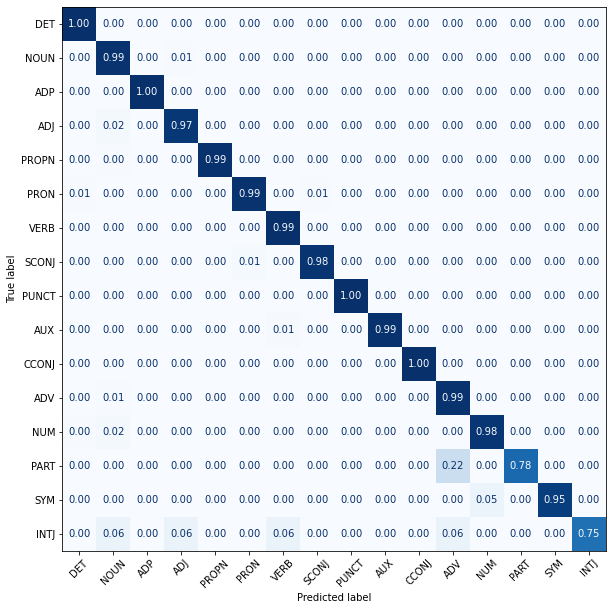

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names,
)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(
    cmap='Blues',
    values_format='.2f',
    colorbar=False,
    ax=ax,
    xticks_rotation=45,
)